# Import Required Packages

In [1]:
import pandas as pd
import numpy as np

# preprocessing related packages
from sklearn.preprocessing import StandardScaler

# regression model related packages
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# visualization related pacakges
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# dataset loading from library
from sklearn.datasets import load_boston

# Load the dataset

In [2]:
boston_data = load_boston()
boston_data = boston_data

X = boston_data.data
y = boston_data.target

# Scale the dataset

In [3]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
#y = scaler.fit_transform(y.reshape(-1, 1))
y = y.flatten()

In [4]:
print('Shape of featrues %d,%d, shape of labels : %d'%(X.shape + (y.shape[0],)))

Shape of featrues 506,13, shape of labels : 506


# UTIL function

In [5]:
def plot_the_prediction(actual_values, predicted_values, title_str):
    # plot two curves
    plt.plot(range(len(actual_values)), actual_values, label='Actual')
    plt.plot(range(len(predicted_values)), predicted_values, label='Predicted')
    plt.xlabel('Iteration Number')
    plt.ylabel('Label Value')
    plt.title(title_str)
    plt.legend()
    plt.show()

# sklearn implementation

In [6]:
sk_reg = SGDRegressor()
sk_reg.fit(X, y)
predicted_values = sk_reg.predict(X)
mse_sklearn = mean_squared_error(y, predicted_values)
print('MSE for skllearn version: ', mse_sklearn)

MSE for skllearn version:  22.931851381723657


/home/amd_3/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [7]:
sk_weights = sk_reg.coef_
sk_bias = sk_reg.intercept_

### Y vs Y_ plot for sklearn implementation

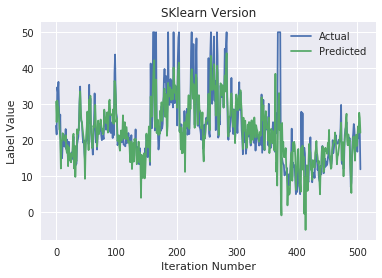

In [8]:
title_str = 'SKlearn Version'
plot_the_prediction(y, predicted_values, title_str)

In [9]:
comparison_df = pd.DataFrame({'Actual':y, 'Predicted':predicted_values}, index=range(len(y)))
comparison_df.head()

,Actual,Predicted
0,24.0,30.692099
1,21.6,25.019310
2,34.7,31.014886
3,33.4,29.664846
4,36.2,29.131055


# Custom Implementation

In [10]:
class SGD_Linear_Regression:
    
    def __init__(self, with_momentum=False):
        
        # initialize the required variables
        self.num_iters = 60000
        self.batch_size = 64
        
        # variables for weight & intercept 
        self.weights = np.nan
        
        # hyper params
        self.with_momentum = with_momentum
        self.tol = 1e-8 # quit the loop if weight chage is below this threshold
        self.momentum = 0.20
        self.learning_rate = 0.001
        
        # Parameters of linear regression
        self.coef_ = np.nan
        self.intercept_ = np.nan
        
        
        
    def adjust_param(self, val, min_bound, max_bound):
        """
        This function does a linear  change in momentum or learning rate as the number of
        iterations increases.
        """
        mappd_value = min_bound + (max_bound - min_bound) * ((val - 1) / (self.num_iters - 1))
        
        return mappd_value
        
              
    def fit(self, X, y):
        """
        This function fit to the data using Stochastic Gradient Descent
        """
        # initialize the weight + bias
        self.weights = np.random.uniform(low=-1.0, high=1.0, size=X.shape[1] + 1)
        
        # to store previous gradients for momentum
        self.prev_grad = np.zeros(X.shape[1] + 1)
        
        print('inital weights assigned', self.weights)
        
        # create a data frame for training input
        train_df = pd.DataFrame(X)
        train_df['Target'] = y
        
        
        # run multiple iterations
        for index in range(1, self.num_iters + 1):
            
            # sample the dataset (current batch of size self.batch_size)
            sample_df = train_df.sample(n=self.batch_size)
            
            # split data set to features & labels
            labels_df = sample_df['Target']
            features_df = sample_df.drop(['Target'], axis=1)
            # add 1 to the last column to account bias as weight value
            features_df['bias'] = 1
            
            # compute the predicted values
            predicted_values =  (self.weights * features_df).sum(axis=1)
            
            # compute loss values
            loss_values = labels_df - predicted_values
            
            # compute the error
            mse_error = mean_squared_error(labels_df, predicted_values)
            
            # print the error
            if (index-1) % 10000 == 0:
                print('Iteration %d loss value: %f : lr:%f'%(index, mse_error, self.learning_rate))
            
            # get the current gradient 
            gradient_weight = -2 * (features_df.mul(loss_values, axis=0)).mean(axis=0)
            
            # run the update step for momentum
            if self.with_momentum:
                
                # momentum term
                gradient_weight = self.momentum * self.prev_grad + self.learning_rate * gradient_weight
                self.prev_grad = gradient_weight
                self.momentum = self.adjust_param(index, 0.10, 0.90)
                
            else: # non-momentum version
                gradient_weight *= self.learning_rate
            
            # compute new weight vector
            new_weights = self.weights - gradient_weight
            
            # adjust learning rate
            self.learning_rate =  1e-3 - self.adjust_param(index, 1e-8, 1e-3)
            
            # terminate early if already converged
            if np.linalg.norm(new_weights - self.weights) < self.tol:
                break
                
            # update current weight as new weight
            self.weights = new_weights
         
        # Assign the final weights and biases
        self.coef_ = self.weights[:-1]
        self.intercept_ = np.array(self.weights[-1:])
            
    def predict(self, X):
        # convert X to data f
        return np.dot(X, self.coef_) + self.intercept_

In [11]:
sgd_reg_without_momentum = SGD_Linear_Regression(with_momentum=False)
sgd_reg_with_momentum = SGD_Linear_Regression(with_momentum=True)

## a) Without momentum version

In [12]:
sgd_reg_without_momentum.fit(X, y)
predicted_values = sgd_reg_without_momentum.predict(X)
mse_without_momentum = mean_squared_error(y, predicted_values)
print('The final MSE value without momentum', mse_without_momentum) 
# get bias and weights
without_weights = sgd_reg_without_momentum.coef_
withouts_bias = sgd_reg_without_momentum.intercept_

inital weights assigned [-0.10699758  0.1326927  -0.59571568 -0.74806401 -0.61674516 -0.83652181
  0.22077201  0.53785738  0.24364007 -0.50370687 -0.63793894  0.30277594
 -0.29353685 -0.52790142]
Iteration 1 loss value: 624.118738 : lr:0.001000
Iteration 10001 loss value: 20.217794 : lr:0.000833
Iteration 20001 loss value: 14.649243 : lr:0.000667
Iteration 30001 loss value: 23.965127 : lr:0.000500
Iteration 40001 loss value: 19.374366 : lr:0.000333
Iteration 50001 loss value: 12.894435 : lr:0.000167
The final MSE value without momentum 21.89824079416991


### Y vs Y_ plot for custom version without momentum

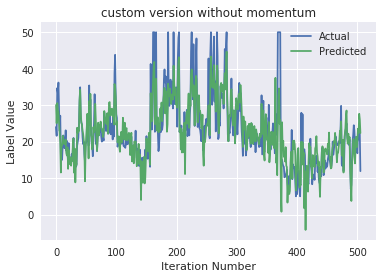

In [13]:
title_str = 'custom version without momentum'
plot_the_prediction(y, predicted_values, title_str)

In [14]:
comparison_df = pd.DataFrame({'Actual':y, 'Predicted':predicted_values}, index=range(len(y)))
comparison_df.head()

,Actual,Predicted
0,24.0,30.031080
1,21.6,25.031326
2,34.7,30.571907
3,33.4,28.612655
4,36.2,27.951806


## b) With momentum version

In [15]:
sgd_reg_with_momentum.fit(X, y)
predicted_values = sgd_reg_with_momentum.predict(X)
mse_withmomentum = mean_squared_error(y, predicted_values)
print('The final MSE value with momentum', mse_withmomentum) 
# get bias and weights
with_weights = sgd_reg_with_momentum.coef_
with_bias = sgd_reg_with_momentum.intercept_

inital weights assigned [ 0.34436705  0.05880664 -0.58824649  0.7545802   0.66926351  0.46999522
 -0.26835904 -0.85713751 -0.57609302 -0.00371549  0.85743946  0.03037301
 -0.27145042 -0.21153613]
Iteration 1 loss value: 527.617726 : lr:0.001000
Iteration 10001 loss value: 26.383148 : lr:0.000833
Iteration 20001 loss value: 19.388833 : lr:0.000667
Iteration 30001 loss value: 16.247267 : lr:0.000500
Iteration 40001 loss value: 18.176866 : lr:0.000333
Iteration 50001 loss value: 20.411124 : lr:0.000167
The final MSE value with momentum 21.898794101026567


### Y vs Y_ plot for Custom version with momentum

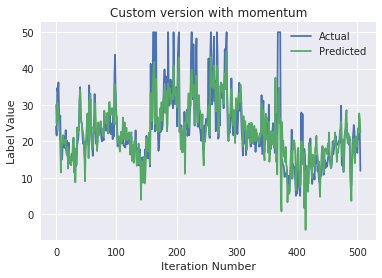

In [16]:
title_str = 'Custom version with momentum'
plot_the_prediction(y, predicted_values, title_str)

In [17]:
comparison_df = pd.DataFrame({'Actual':y, 'Predicted':predicted_values}, index=range(len(y)))
comparison_df.head()

,Actual,Predicted
0,24.0,30.016968
1,21.6,25.032358
2,34.7,30.575248
3,33.4,28.623558
4,36.2,27.942372


## Comparsion of Weights from all three models

In [18]:
weights_table = pd.DataFrame({'SK_Learn':sk_weights, 'Without_momentum':without_weights, 
                              'With_momentum' : with_weights}, index=range(len(sk_weights)))
bias_table = pd.DataFrame({'SK_Learn':sk_bias, 'Without_momentum': withouts_bias, 
                              'With_momentum' : with_bias})

## a ) Weights table

In [19]:
weights_table = weights_table[['SK_Learn', 'Without_momentum', 'With_momentum']]
weights_table

,SK_Learn,Without_momentum,With_momentum
0,-0.752903,-0.906675,-0.922864
1,0.597092,1.074215,1.091047
2,-0.508069,0.124804,0.143693
3,0.775476,0.685810,0.690379
4,-1.044620,-2.051741,-2.067917
5,3.147765,2.676833,2.650176
6,-0.261840,0.022977,0.021907
7,-2.043230,-3.096169,-3.118597
8,0.844388,2.610523,2.664484
9,-0.524075,-2.034974,-2.079862


## b) Bias Table

In [20]:
bias_table = bias_table[['SK_Learn', 'Without_momentum', 'With_momentum']]
bias_table

,SK_Learn,Without_momentum,With_momentum
0,22.341985,22.531998,22.533082


## Observation

%%HTML
<ul>
<li> Bias holds larger values when compared with weights </li>
</ul>

# Predict House Price given a Raw Data Point

## Proceudre for predicting the house price

%%HTML
<ol>
<li> As the first step, we need to scale the given data point ($x$) to scaled domain using the parameters 
     of standard scaler (the scaler we used at the time of training)</li>
<li> We need to use two parameters mean ($\mu$) and standard deviation ($\sigma$) of the scaler and scale it using
     $\frac{x-\mu}{\sigma}$ </li>
<li> Once the scaling is done, we can feed the point to model and get the predicted value as output from it </li>
</ol>

In [21]:
def predict_the_price(model, scaler, x):
    """
    This function helps to predict the price of a data point
    given the model and its scaler.
    """
    
    # get parameters
    mu = scaler.mean_
    sigma = np.sqrt(scaler.var_)
    
    # scale the input data
    x_new = (x - mu) / sigma
    
    # predict the price
    predicted_price = model.predict(x_new)
    
    return predicted_price  

## Raw input data

In [22]:
raw_data_points = boston_data.data[0:5]
raw_data_points_labels = boston_data.target[0:5]

## Predict the price

### a) using the sklearn version

In [23]:
predicted_values_ver1 = predict_the_price(sk_reg, scaler, raw_data_points)

### b) using the custom without momentum version

In [24]:
predicted_values_ver2 = predict_the_price(sgd_reg_without_momentum, scaler, raw_data_points)

### c) using the custom with momentum version

In [25]:
predicted_values_ver3 = predict_the_price(sgd_reg_with_momentum, scaler, raw_data_points)

## Prediction Results

In [26]:
predicted_df = pd.DataFrame({'SK_learn' : predicted_values_ver1,
              'Custom_without_momentum' :predicted_values_ver2,
             'Custom_with_momentum' :predicted_values_ver3,
             'Actual' : raw_data_points_labels}, index=range(len(predicted_values_ver1)))
predicted_df = predicted_df[['SK_learn', 'Custom_without_momentum', 'Custom_with_momentum', 'Actual']]
predicted_df

,SK_learn,Custom_without_momentum,Custom_with_momentum,Actual
0,30.692099,30.031080,30.016968,24.0
1,25.019310,25.031326,25.032358,21.6
2,31.014886,30.571907,30.575248,34.7
3,29.664846,28.612655,28.623558,33.4
4,29.131055,27.951806,27.942372,36.2


# Procedure Summary

%%HTML
<ol>
<li> Scale the featues of dataset using standard scaler </li>
<li> Train all the three models using the scaled dataset</li>
<li> Evaluate the models using MSE metric </li>
<li> Compare the weights, biases obtained for all models </li>
<li> Compare the actual and predicted values of all models </li>
<li> Predict the house price given a non-scaled raw input data set </li>
</ol>

# Results Summary

In [27]:
from prettytable import PrettyTable

In [28]:
ptable = PrettyTable()
ptable.title = 'SGD Regression Method Comparison'
ptable.field_names = ['Method', 'MSE Value']

In [29]:
ptable.add_row(['Sk-learn Version', mse_sklearn])
ptable.add_row(['Custom Version without momentum', mse_without_momentum])
ptable.add_row(['Custom Version with momentum', mse_withmomentum])

In [30]:
print(ptable)

+------------------------------------------------------+
|           SGD Regression Method Comparison           |
+---------------------------------+--------------------+
|              Method             |     MSE Value      |
+---------------------------------+--------------------+
|         Sk-learn Version        | 22.931851381723657 |
| Custom Version without momentum | 21.89824079416991  |
|   Custom Version with momentum  | 21.898794101026567 |
+---------------------------------+--------------------+


# Conclusion

%%HTML
<ul>
<li> The weights obtained from both momentum and non momentum version are very similar </li>
<li> Many of the weights obtained from sklearn implementation are close to the custom implementation weights</li>
<li> The final MSE error from all three methods are roughly same </li>
<li> The performace of momentum version is better compared to non-momentum version (from the mse values obtained
     at different iterations 10K, 20K, 30K etc.)</li>
</ul>